# 11_03: Evaluating model fit

In [1]:
import math
import collections
import dataclasses
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as pp

In [5]:
import statsmodels
import statsmodels.formula.api as smf

When analyzing data, we often have many different choices in setting up a model. How do we decide which is best for us?

Let's resume things where we left them in the last video, with the gapminder 1985 data, and our dataset plotting function

In [8]:
gm = pd.read_csv('gapminder2.csv', dtype_backend='pyarrow')

gdata = gm[gm.year == 1985].copy()
gdata['region'] = gdata['region'].astype('category')

In [40]:
continent = gdata.region.map({'Africa': 'skyblue', 'Europe': 'gold', 'America': 'palegreen', 'Asia': 'coral', 'Oceania': 'teal'})
population = 1e-6 * gdata.population

def plotbabies():
    gdata.plot.scatter('age5_surviving', 'babies_per_woman', c=continent, s=population,
                       linewidths=0.5, edgecolor='black', alpha=0.6, figsize=(5,3.5))

# define a function to plot residuals
def plotresidual(fit):
    pp.scatter(gdata.age5_surviving, fit.predict(gdata), color=continent, s=15, marker='s', ec='k', lw=0.25);

We consider three different fits: constants by region, constants by region plus survival fraction, and the most complex fit we set up, which includes constants by region, survival fraction grouped by region, and population.

In [35]:
groupfit = smf.ols(formula='babies_per_woman ~ -1 + region', data=gdata).fit()

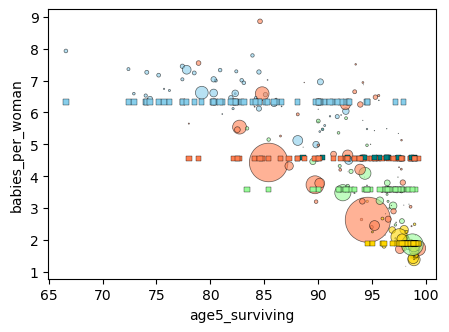

In [43]:
plotbabies()
plotresidual(groupfit)

In [13]:
survivingfit = smf.ols(formula='babies_per_woman ~ -1 + region + age5_surviving', data=gdata).fit()

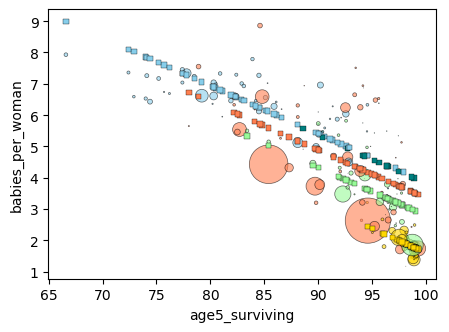

In [21]:
plotbabies()
plotresidual(survivingfit)

In [22]:
twovariablefit = smf.ols(formula='babies_per_woman ~ -1 + region + age5_surviving:region + population', data=gdata).fit()

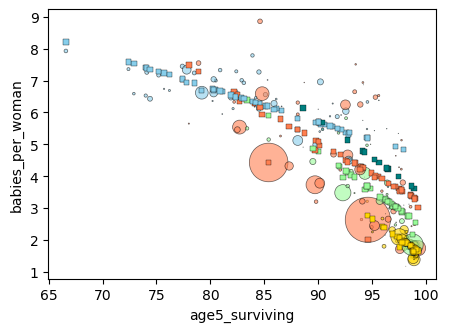

In [24]:
plotbabies()
plotresidual(twovariablefit)

Visually, it looks like the more complex model does better. But we should dig into details. The first thing we do is to compare the residuals. This is how we'd compute them, but we can also get them from the fit object.

In [26]:
gdata.babies_per_woman - survivingfit.predict(gdata)

169      0.964485
393       0.76746
617      1.027615
828     -0.398828
1052     0.111648
           ...   
40930    0.450375
41153   -0.077165
41351    3.149024
41575    0.466187
41783    0.734873
Length: 195, dtype: double[pyarrow]

Histogramming the residuals together shows that the distribution of errors for the group constant fit is broader, but not by much, and the other two models are very similar.

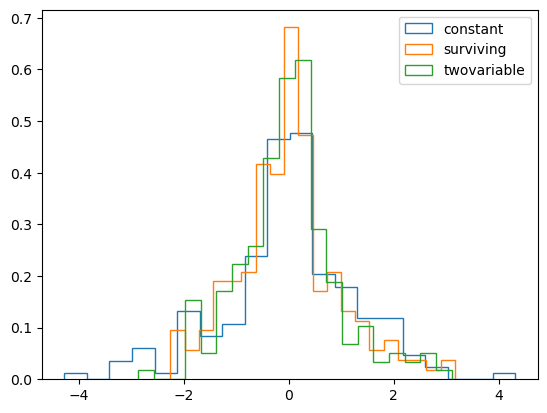

In [56]:
pp.hist(groupfit.resid, histtype='step', density=True, bins=20, label='constant')
pp.hist(survivingfit.resid, histtype='step', density=True, bins=20, label='surviving')
pp.hist(twovariablefit.resid, histtype='step', density=True, bins=20, label='twovariable')
pp.legend();

To distill the comparison into a single number, we can look at the mean square error of the residual, which is conveniently available in the fit object. This is in a sense the "typical" error, and it includes a very simple correction for the complexity of the model. Even our best model has a typical error of one child per woman, not great.

In [66]:
[fit.mse_resid for fit in [groupfit, survivingfit, twovariablefit]]

[1.6102173625174048, 1.0148569308436735, 0.9308093449888896]

Beyond the MSE, there are various more sophisticated ways that statisticians have devised to evaluate goodness of fit. Explaining their mathematics is outside the scope of this course, but we can still look at them. One is R^2 statistic, which qualitatively describes the fraction of data variation that is _explained_ by the fit. For a perfect model, R^2 would reach 1.

In [68]:
[fit.rsquared for fit in [groupfit, survivingfit, twovariablefit]]

[0.6150742846880249, 0.7586732603637679, 0.7845148347657889]

The R^2 statistic does not take into account the number of fit parameters, so it will not penalize **overfitting**---a model that is very good on the data used to train it, but not predictive. That correction is included in the _F statistic_, which measures how much each fit parameter contributes to R^2 compared to an explanatory variable that has nothing to do with the dataset, but takes random values.

If F = 0, the model explains nothing; for F = 1 the model explains about half of the variation; for large F, the model seems to have explanatory power.

Here we see that the simpler one-variable fit by region, survivingfit, seems to hit the sweet spot.

In [70]:
[fit.fvalue for fit in [groupfit, survivingfit, twovariablefit]]

[75.90043314981475, 118.83411380346192, 66.9887086844285]

statsmodels computes many measures of goodness of fit; asking for a _summary_ of a fit will collect them in a nice tabular format. The table includes also the best-fit parameters, and their estimated error.

This table is where you go _after_ you've taken a nice course in statistics!

In [90]:
twovariablefit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       babies_per_woman   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     66.99
Date:                Fri, 20 Sep 2024   Prob (F-statistic):           6.02e-56
Time:                        09:43:25   Log-Likelihood:                -264.04
No. Observations:                 195   AIC:                             550.1
Df Residuals:                     184   BIC:                             586.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
region[Africa]                    15.4144      1.583      9.735      0.000      12.290      18.539
region[America]                   26.7269      4.362      6.127      0.000      18.121      35.333
region[Asia]                      23.0048      2.228     10.327      0.000      18.610      27.400
region[Europe]                    24.8203     13.614      1.823      0.070      -2.039      51.680
region[Oceania]                   27.6798      8.762      3.159      0.002      10.393      44.967
age5_surviving:region[Africa]     -0.1079      0.019     -5.746      0.000      -0.145      -0.071
age5_surviving:region[America]    -0.2437      0.046     -5.301      0.000      -0.334      -0.153
age5_surviving:region[Asia]       -0.1989      0.024     -8.261      0.000      -0.246      -0.151
age5_surviving:region[Europe]     -0.2333      0.139     -1.682      0.094      -0.507       0.040
age5_surviving:region[Oceania]    -0.2432      0.092     -2.636      0.009      -0.425      -0.061
population                     -2.044e-09   7.31e-10     -2.797      0.006   -3.49e-09   -6.02e-10
==============================================================================
Omnibus:                       11.488   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               15.230
Skew:                           0.401   Prob(JB):                     0.000493
Kurtosis:                       4.110   Cond. No.                     1.97e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Before you go off and study a lot of math, though, let me show you the pragmatic approach to goodness of fit that is typical of machine learning. The idea is to evaluate out-of-sample goodness of fit... that is, we exclude some of the data from the fit to test the true predictive power of the model.

We start by shuffling our data. The method sample is really meant to draw a number of random rows, but if we set the number to the length of the dataset, the effect will be the same as shuffling.

In [113]:
shuffled = gdata.sample(len(gdata))

Then we take 90% of the data for training, and the rest for testing

In [166]:
ntrain = int(0.9 * len(gdata))
training, testing = shuffled.iloc[:ntrain], shuffled.iloc[ntrain:]

In [103]:
len(training), len(testing)

(156, 39)

In [96]:
grouptrain = smf.ols(formula='babies_per_woman ~ -1 + region', data=training).fit()
survivingtrain = smf.ols(formula='babies_per_woman ~ -1 + region + age5_surviving', data=training).fit()
twovariabletrain = smf.ols(formula='babies_per_woman ~ -1 + region + age5_surviving:region + population', data=training).fit()

The best fit parameters are a bit different than in the original fit.

In [98]:
grouptrain.params

region[Africa]     6.303947
region[America]    3.522069
region[Asia]       4.471282
region[Europe]     1.882222
region[Oceania]    4.589286
dtype: float64

In [100]:
groupfit.params

region[Africa]     6.326296
region[America]    3.581143
region[Asia]       4.546400
region[Europe]     1.885476
region[Oceania]    4.589286
dtype: float64

And so are the mean squared errors of the residuals. We need to compute those by hand for the test data.

In [171]:
[fit.mse_resid for fit in [grouptrain, survivingtrain, twovariabletrain]] # training MSE

[1.7692777134675945, 1.0564671605446765, 0.9850855120544252]

In [175]:
def mse_test(fit, testing):
    return np.sum((fit.predict(testing) - testing.babies_per_woman)**2) / (len(testing) - len(fit.params))

The training MSE is lowest for the most complicated model, but the testing MSE is lowest for survivingfit... the same result with found with the F statistic!

In [176]:
[mse_test(fit, testing) for fit in [grouptrain, survivingtrain, twovariabletrain]] # testing MSE

[2.4068262571451995, 1.68032759743861, 2.3637035396929713]

To get accurate results it's best to repeat for many different random partitions of the dataset, and take the average.

In [178]:
mses = []
for i in range(100):
    shuffled = gdata.sample(len(gdata))
    training, testing = shuffled.iloc[:ntrain], shuffled.iloc[ntrain:]
    mses.append([mse_test(fit, testing) for fit in [grouptrain, survivingtrain, twovariabletrain]])

print(np.array(mses).mean(axis=0))

[2.00966847 1.38868194 1.92847857]


This is a very pragmatic, straightforward approach. I recommend it!